# Information Retrieval and Web Analytics Project
## Indexing & Evaluation

#### Packages

We first import all the packages that we need for text processing, such as:
- Demoji
- Re
- Deep translator

In [1]:
import time
import string
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import json
import nltk
import demoji
import re
nltk.download('stopwords');
from deep_translator import GoogleTranslator

from collections import defaultdict
import math
import numpy as np
import collections
from numpy import linalg as la
import matplotlib.cm as cm
import random
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load data 

**Read the file with the tweets:**

In [2]:
docs_path = 'dataset_tweets_WHO.txt'

# Read the JSON file in a unique string
with open(docs_path) as fp:
    corpus = fp.readlines()[0]

# Load the JSON file as a dictionary
corpus = json.loads(corpus)

In [3]:
print("There are \033[1m%i tweets\033[0m in the dataset" %len(corpus))

There are 2399 tweets in the dataset


## Text Processing

### Functions

In [4]:
def italics_to_plaintext(text):
    #difference between an italic lowecase character and its corresponding plaintext lowercase character
    diff_lower = ord('𝘢') - ord('a')
    #difference between an italic uppercase character and its corresponding plaintext uppercase character
    diff_upper = ord('𝘈') - ord('A')
    
    plaintext = ""
    for c in text:
        # if the character is italic lowercase, get the corresponding plaintext lowercase character
        if ord(c) >= ord('𝘢') and ord(c) <= ord('𝘻'):
            plaintext += chr(ord(c) - diff_lower)
        # else if the character is italic uppercase, get the corresponding plaintext uppercase character
        elif ord(c) >= ord('𝘈') and  ord(c) <= ord('𝘡'):
            plaintext += chr(ord(c) - diff_upper)
        else:
            plaintext += c
    
    return plaintext

def bold_to_plaintext(text):
    #difference between a bold lowecase character and its corresponding plaintext lowercase character
    diff_lower = ord('𝐚') - ord('a')
    #difference between a bold uppercase character and its corresponding plaintext uppercase character
    diff_upper = ord('𝐀') - ord('A')
    
    plaintext = ""
    for c in text:
        # if the character is bold lowercase, get the corresponding plaintext lowercase character
        if ord(c) >= ord('𝐚') and ord(c) <= ord('𝐳'):
            plaintext += chr(ord(c) - diff_lower)
        # else if the character is bold uppercase, get the corresponding plaintext uppercase character
        elif ord(c) >= ord('𝐀') and  ord(c) <= ord('𝐙'):
            plaintext += chr(ord(c) - diff_upper)
        else:
            plaintext += c
    
    return plaintext

def getTerms(text, stemming, stops):
    # Text to lowercase
    text = text.lower()
    # Text delete italic letter type if needed
    text = italics_to_plaintext(text)
    # Text delete bold letter type if needed
    text = bold_to_plaintext(text)
    # Delete all urls
    text = re.sub(r'http\S+', ' ', text) 
    # Delete all non-alphanumerical characters (it includes emojis) except '#' and '@'
    text = re.sub(r'[^A-Za-z0-9#@]+', ' ', text)
    # Text tokenization
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stops]
    # Get the stem of each word
    words = [stemming.stem(word) for word in words]
    
    return words

### Process tweets

In [5]:
stemming = PorterStemmer()
# Delete also "amp" (&) and "rt"
stops = set(stopwords.words("english")).union(set({'amp', 'rt'}))

# Dictionary where we'll save all the processed tweets
data = {}
for tweet in corpus:
    
    #In case that the tweet is not in english, we traduce it
    lang = corpus[tweet]['lang']
    if lang != 'en':
        text_tweet = GoogleTranslator(target='en').translate(corpus[tweet]['full_text'])
    else:
        text_tweet = corpus[tweet]['full_text']
    
    # Get the text tokenized and cleaned 
    text_tweet_processed = getTerms(text_tweet, stemming, stops)
    
    if text_tweet_processed != []: #In case that the text is not null                       
        data[tweet] = {}
        data[tweet]['org_text'] = text_tweet
        data[tweet]['text'] = text_tweet_processed
        
        if 'retweeted_status' in corpus[tweet]:
            # Save the original tweet's user
            data[tweet]['user'] = corpus[tweet]['retweeted_status']['user']['name']
            # Save the original tweet's url
            try:
                data[tweet]['url'] = corpus[tweet]['retweeted_status']['entities']['media'][0]['url']
            except: 
                data[tweet]['url'] = ''
        else:
            data[tweet]['user'] = corpus[tweet]['user']['name']
            try:
                data[tweet]['url'] = corpus[tweet]['entities']['media'][0]['url']
            except: 
                data[tweet]['url'] = ''

        # Save all emojis used with its meaning
        data[tweet]['emojis'] = demoji.findall(corpus[tweet]['full_text'])

        # Save creation data
        data[tweet]['date'] = corpus[tweet]['created_at']

        # Save the number of retweets of this tweet
        data[tweet]['retweets'] = corpus[tweet]['retweet_count']

        # Save the number of 'favorites' of this tweet
        data[tweet]['favorites'] = corpus[tweet]['favorite_count']
        
        # Save the hashtags of this tweet
        hashtags = []
        for i in corpus[tweet]['entities']['hashtags']:
            hashtags.append(i['text'])
    
        data[tweet]['hashtags'] = hashtags

        # Save the full name of all the users mentioned
        data[tweet]['user_mentions'] = list()
        ## List of dictionaries, each with information of a user mentioned
        users_data = corpus[tweet]['entities']['user_mentions']
        for user in users_data:
            data[tweet]['user_mentions'].append(user['name'])        

## Indexing

### Functions

In [6]:
def create_index_tfidf(data, num_d):
    """
    Implement the inverted index and compute tf, df and idf
    
    Input:
    * lines: collection of Wikipedia articles
    * num_d: total number of documents
    
    Returns:
    * index: the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    * list of document these keys appears in (and the positions) as values
    * tf: normalized term frequency for each term in each document
    * df: number of documents each term appear in
    * idf: inverse document frequency of each term
    """
        
    index = defaultdict(list)
    tf = defaultdict(list) #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int) #document frequencies of terms in the corpus
    idf = defaultdict(float)
    
    for tweet_id in data:   
        terms = data[tweet_id]['text']      

        termdictTweet = {}

        for position, term in enumerate(terms): # Tweet's terms
            try:
                # If the term is already in the dict append the position to the corrisponding list
                termdictTweet[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictTweet[term] = [tweet_id, array('I',[position])] 
        
        # Normalize term frequencies
        norm = 0
        for term, posting in termdictTweet.items(): 
            norm += len(posting[1])**2
        norm = math.sqrt(norm)


        # Calculate the tf and df weights
        for term, posting in termdictTweet.items():     
            # Append the tf
            tf[term].append(np.round(len(posting[1])/norm,4))
            # Increment the document frequency of current term
            df[term] += len(posting)
        
        # Merge the current tweet index with the main index
        for termtweet, postingtweet in termdictTweet.items():
            index[termtweet].append(postingtweet)
            
        # Compute idf
        for term in df:
            idf[term] = np.round(np.log(float(num_d/df[term])),4)
            
    return index, tf, df, idf

In [7]:
def rankTweets(terms, tweets, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    * terms: list of query terms
    * docs: list of documents, to rank, matching the query
    * index: inverted index data structure
    * idf: inverted document frequencies
    * tf: term frequencies
    * titleIndex: mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """
        
    tweetVectors = defaultdict(lambda: [0]*len(terms))
    queryVector = [0]*len(terms)    

    # Compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query 
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf normalized
        queryVector[termIndex] = (query_terms_count[term] / query_norm) * idf[term]

        # Generate tweetVectors for matching docs
        for tweetIndex, (tweet, postings) in enumerate(index[term]):
            if tweet in tweets:
                tweetVectors[tweet][termIndex] = tf[term][tweetIndex]

    # Score of each tweet
    tweetScores = [ [np.dot(curTweetVec, queryVector), tweet] for tweet, curTweetVec in tweetVectors.items() ]
    tweetScores.sort(reverse=True)
    scores = [x[0] for x in tweetScores]
    resultTweets = [x[1] for x in tweetScores]
    #print document titles instead if document id's
    #resultDocs=[ titleIndex[x] for x in resultDocs ]
    if len(resultTweets) == 0:
        print("No results found, try again")
        query = input()
        tweets = search_tf_idf(query, index)    
    #print ('\n'.join(resultDocs), '\n')
    return resultTweets, scores

In [8]:
def search_tf_idf(query, index):
    stemming = PorterStemmer()
    stops = set(stopwords.words("english")).union(set({'amp', 'rt'}))
    
    query = getTerms(query, stemming, stops)
    tweets = set()

    for i, term in enumerate(query):
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs = [posting[0] for posting in index[term]]
            
            # if this is the first word of the query, save all the tweets with this word
            if i == 0:
                tweets = tweets.union(termDocs)
            # for the next words, only keey those that contain that word and all the past words of the query
            else:
                tweets = tweets.intersection(termDocs)
        except:
            #term is not in index
            pass
    
    tweets = list(tweets)
    ranked_tweets, scores = rankTweets(query, tweets, index, idf, tf)   
    return ranked_tweets, scores

**Create the index:**

In [9]:
start_time = time.time()
num_d = len(data)
index, tf, df, idf = create_index_tfidf(data, num_d)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 57.17 seconds


**Testing the retrieval system:**

In [10]:
print("\033[1mInsert a query:\033[0m\n")
query = input()
ranked_tweets, scores = search_tf_idf(query, index)    
top = 5

print("\n======================\n\033[1mTop {} results out of {} for the seached query:\033[0m\n".format(top, len(ranked_tweets)))
for d_id in ranked_tweets[:top] :
    print("\n\033[1mTweet id = {}\033[0m".format(d_id))
    print("   - Tweet_text = {} ".format(data[d_id]['org_text']))
    print("   - Tweet_user = {} ".format(data[d_id]['user']))
    print("   - Tweet_date = {} ".format(data[d_id]['date']))
    print("   - Tweet_hashtags = {} ".format(data[d_id]['hashtags']))
    print("   - Tweet_likes = {} ".format(data[d_id]['favorites']))
    print("   - Tweet_retweets = {} ".format(data[d_id]['retweets']))
    print("   - Tweet_url = {} ".format(data[d_id]['url']))

Insert a query:

cov

Top 5 results out of 5 for the seached query:


Tweet id = 1997
   - Tweet_text = RT @WHO_Europe: All viruses change over time, including SARS-CoV-2, the virus that causes #COVID19.

The Delta variant can spread more easi… 
   - Tweet_user = WHO/Europe 
   - Tweet_date = Thu Jul 15 10:54:39 +0000 2021 
   - Tweet_hashtags = ['COVID19'] 
   - Tweet_likes = 0 
   - Tweet_retweets = 105 
   - Tweet_url = https://t.co/t321gUFF8j 

Tweet id = 2022
   - Tweet_text = Learn how to safely perform SARS-CoV-2 Antigen RDT testing, ensure quality testing and interpret #COVID19 results in this free 🆕 online course on #OpenWHO

👉 https://t.co/KwNzHOrPdt https://t.co/LwIrN4XcJp 
   - Tweet_user = World Health Organization (WHO) 
   - Tweet_date = Tue Jul 13 16:12:13 +0000 2021 
   - Tweet_hashtags = ['COVID19', 'OpenWHO'] 
   - Tweet_likes = 191 
   - Tweet_retweets = 80 
   - Tweet_url = https://t.co/LwIrN4XcJp 

Tweet id = 1136
   - Tweet_text = "I wish to emphasise that SAGO i

## Evaluation

### Functions

In [12]:
from IPython.display import clear_output

def define_relevance(ranked_tweets, top, query):
    relevances = []
    for tweet_id in ranked_tweets[:top]:
        print(query)
        print(data[tweet_id]['org_text'])
        relevance = int(input())
        relevances.append(relevance)
        clear_output()
    return relevances

In [13]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    relevant = y_true[:k].tolist()
    return relevant.count(1)/k

In [14]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    
    gtp =  np.sum(y_true==1)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])           

    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i+1)
    return prec_at_i/gtp

In [15]:
def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res["q_id"].unique(): #loop over all query id
        curr_data = search_res[search_res["q_id"]==q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["y_true"]), 
                                      np.array(curr_data["y_score"]), k)) #append average precision for current query
    return np.sum(avp)/len(avp), avp # return mean average precision

In [16]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''

    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(y_true[:k])==0: # if there are not relevant doument return 0
        return 0
    return 1/(np.argmax(y_true==1)+1) # hint: to get the position of the first relevant document use "np.argmax"



In [17]:
def mean_rr_at_k(search_results, k=10):
    RRs = []
    
    for q in search_results["q_id"].unique(): # loop over all query ids
        labels =  np.array(search_results[search_results['q_id']==q]['y_true'])# get labels for current query
        scores = np.array(search_results[search_results['q_id']==q]['y_score']) # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k)) # append RR for current query
        
    mrr = np.round(float(sum(RRs)/len(RRs)),4) # Mean RR at current k
    return mrr

In [18]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2**y_true-1 # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true))+2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = dcg_at_k(y_true, y_true, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k)/dcg_max,4)  # return ndcg@k

**This are the queries we selected to evaluate the retrieval system:**

In [11]:
q = ["#COVID19",
     "covid vaccine",
     "global pandemic",
     "#mentalhealth",
     "death risk"]

#### Evaluating the search system

**This code allows us to assign binary relevance to the retrieved tweets for each selected query:**

In [19]:
relevance = list() # relevance[i] = relevance of the retrieved tweets for the i-est query
y_score = list()

# number of tweets we will recover for each query
top = 15

for query in q:
    # Retrieve 15 tweets for a given query and its scores
    ranked_tweets, scores = search_tf_idf(query, index)
    # Assign interactively a score to each tweet (must be 0 or 1)
    rel = define_relevance(ranked_tweets, top, query)
    relevance.append(rel)
    y_score = y_score + scores[:15]

The ground truth for the selected queries is:

```Python

relevance = [[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
      [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
      [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
      [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1],
      [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1]]

y_score = [0.34987308,0.2474,0.2474,0.2474,0.2474,0.2474,0.2474,0.2474,0.2474, 0.2474,0.2474,0.2474,0.2474,0.2474, 0.2474,1.392371769293295,1.2709439987153912,1.0173532614025593,0.9844990014546955,0.9465861703049014,0.9256499123112245,0.8988768555343789,0.8039141118773004,0.7783831447301515,0.7572689362439212,0.7550316503882469,0.7156191447505056,0.7049926874742916,0.6800275047470412,0.6800275047470412,0.6829378714055913,0.6453762884782838,0.625056118480919,0.6211869362402834,0.6132782085222209,0.6022981271447355,0.6022981271447355,0.5817934022774811,0.5817934022774811,0.5771986436265345,0.563316617232263,0.563316617232263,0.5464171187152951,0.5464171187152951,0.5310949067265776,1.4652,1.19618928,1.19618928,1.03618944,0.97670232,0.9265924799999999,0.9265924799999999,0.8835156,0.8835156,0.8835156,0.8835156,0.8835156,0.8460064800000001,0.8460064800000001,0.8460064800000001,1.003607289424056,0.8193782119127307,0.7695554468971232,0.7479761601387709,0.7279835856420621,0.7279835856420621,0.6765741083648111,0.6476959452028983,0.6346849046574212,0.6108842207327679,0.5893049339744156,0.5610614557171605,0.5610614557171605,0.5610614557171605,0.5524932095042852]

```

In [32]:
q_id = []
y_true = []
for i in range(len(relevance)):
    re = 0
    for j in relevance[i]:
        q_id.append(i)
        y_true.append(j)
            

ys_df = pd.DataFrame(columns = ['q_id', 'y_true', 'y_score'])
ys_df['q_id'] = q_id
ys_df['y_true'] = y_true
ys_df['y_score'] = y_score
ys_df

,q_id,y_true,y_score
0,0,1,0.349873
1,0,1,0.247400
2,0,0,0.247400
3,0,0,0.247400
4,0,1,0.247400
...,...,...,...
70,4,0,0.589305
71,4,0,0.561061
72,4,1,0.561061
73,4,0,0.561061


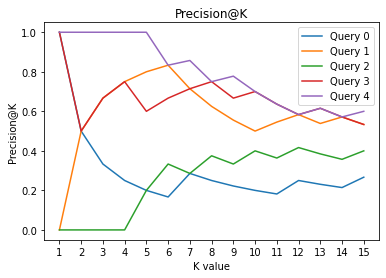

In [33]:
k = 15

for i in range(len(ys_df['q_id'].unique())):
    prec_at_ks = []
    for j in range(k):
        current_query_res = ys_df[ys_df["q_id"] == i] 
        prec_at_k = precision_at_k(current_query_res["y_true"], current_query_res["y_score"], j+1)
        prec_at_ks.append(prec_at_k)
    plt.plot(range(1, k+1), prec_at_ks, label = 'Query ' + str(i))

plt.legend()
plt.xticks(range(1, k+1))
plt.xlabel('K value')
plt.ylabel('Precision@K')
plt.title("Precision@K")
plt.show()

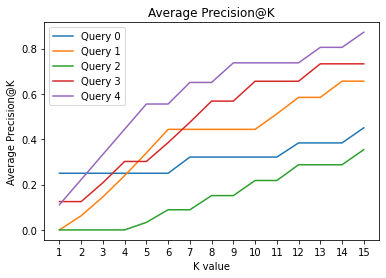

In [34]:
k = 15
for i in range(len(ys_df['q_id'].unique())):
    prec_at_ks = []
    for j in range(k):
        current_query_res = ys_df[ys_df["q_id"] == i] 
        prec_at_k = avg_precision_at_k(np.array(current_query_res["y_true"]), np.array(current_query_res["y_score"]), j+1)
        prec_at_ks.append(prec_at_k)
    plt.plot(range(1, k+1), prec_at_ks, label = 'Query ' + str(i), )

plt.legend()
plt.xticks(range(1, k+1))
plt.xlabel('K value')
plt.ylabel('Average Precision@K')
plt.title("Average Precision@K")
plt.show()

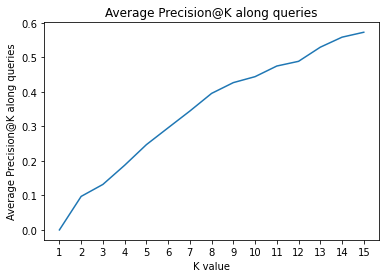

In [35]:
k = 15
avg_prec = []
for j in range(k):
    map_prec = map_at_k(ys_df, j)
    avg_prec.append(map_prec[0])

plt.plot(range(1, k+1), avg_prec)
plt.xticks(range(1, k+1))
plt.xlabel('K value')
plt.ylabel('Average Precision@K along queries')
plt.title('Average Precision@K along queries')
plt.show()

In [36]:
mrr = mean_rr_at_k(ys_df, 15)
print('The Mean Reciprocal Rank at k = 15 is {}'.format(mrr))

The Mean Reciprocal Rank at k = 15 is 0.74


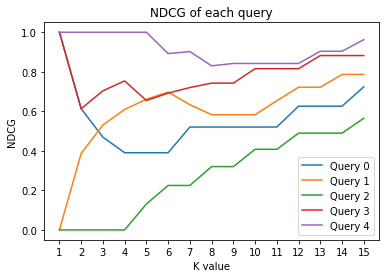

In [37]:
k = 15
for i in range(len(ys_df['q_id'].unique())):
    ncdg_at_ks = []
    for j in range(k):
        current_query_res = ys_df[ys_df["q_id"] == i]
        ncdg_q = ndcg_at_k(np.array(current_query_res["y_true"]), np.array(current_query_res["y_score"]), k=j+1)
        ncdg_at_ks.append(ncdg_q)
    plt.plot(range(1, k+1), ncdg_at_ks, label = 'Query ' + str(i), )

plt.legend()
plt.xticks(range(1, k+1))
plt.xlabel('K value')
plt.ylabel('NDCG')
plt.title('NDCG of each query')
plt.show()

## Vector representation of tweets

In [38]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt

In [39]:
## Transform each word to a 2D vector
sentences = list()
for tw_id in data:
    sentences.append(data[tw_id]['text'])

model = Word2Vec(sentences)

X = model.wv[model.wv.key_to_index]

tsne = TSNE(perplexity=5, n_components=2)
X_tsne = tsne.fit_transform(X)

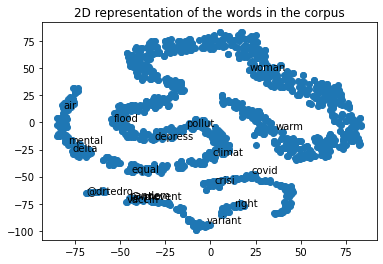

In [40]:
## Plot the 2D representation of each word
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

## Print the name of a subsample of them

# list of words we want to plot
words = ['covid', 'vaccine', 'pandemic', 'variant', 'delta',
         'equallity', 'woman', 'right',
         'mental', 'prevention', 'depression',
         'climate', 'crisis', 'warm',"flood", 'pollution', 'air',
         '@drtedro', '@who']

stemming = PorterStemmer()
for i, word in enumerate(words):
    words[i] = stemming.stem(word)

for word in words:
    i = model.wv.key_to_index[word]
    plt.annotate(word, xy=(X_tsne[i, 0], X_tsne[i, 1]))

plt.title('2D representation of the words in the corpus')
plt.show()

In [41]:
## Represent each tweet as the mean of each of it's words

# number of tweets
n = len(sentences)
# number of components of each tweet
m = 2
X_tweets = np.zeros((n, m))

for i, sentence in enumerate(sentences):
    words_ids = list()

    for word in sentence:
        if word in model.wv.key_to_index:
            words_ids.append(model.wv.key_to_index[word])

    X_tweets[i,:] = X_tsne[words_ids,:].mean(axis=0)

In [42]:
for i, tw_id in enumerate(data.keys()):
    print("i = " + str(i))
    print("tw_id = " + tw_id)
    print(data[tw_id]["org_text"])
    print('-'*50)

i = 0
tw_id = 0
It's International Day for Disaster Risk Reduction

#OpenWHO has launched a multi-tiered core curriculum to help equip you with the competencies needed to work within public health emergency response.

Start learning today &amp; be #Ready4Response:
👉 https://t.co/hBFFOF0xKL https://t.co/fgZY22RWuS
--------------------------------------------------
i = 1
tw_id = 1
#COVID19 has shown how health emergencies and disasters affect entire communities – especially those with weak health systems, and vulnerable populations like migrants, indigenous peoples, and those living in fragile humanitarian conditions. https://t.co/jpUQpnu0V1
--------------------------------------------------
i = 2
tw_id = 2
It's International Day for Disaster Risk Reduction
 
To better respond to emergencies countries must:
✅ invest in health care systems
✅ achieve gender equity
✅ protect marginalised groups
✅ ensure ready &amp; equitable access to supplies
 
A strong &amp; resilient health system is 🔑 h

i = 716
tw_id = 717
RT @DrTedros: We will continue to push for #VaccinEquity. We never give up.
--------------------------------------------------
i = 717
tw_id = 718
RT @DrTedros: The longer #COVID19 vaccine inequity persists, the more:
-the virus will keep circulating
-the higher the chances that more v…
--------------------------------------------------
i = 718
tw_id = 719
RT @DrTedros: Over 5.7 billion #COVID19 vaccine doses have been administered globally, but only 2% were given in Africa. This hurts all of…
--------------------------------------------------
i = 719
tw_id = 720
RT @DrTedros: Thank you #Qatar for delivering more critical supplies to #Afghanistan. Since 30 August, @WHO has delivered life-saving medic…
--------------------------------------------------
i = 720
tw_id = 721
#AskWHO Live Q&amp;A with Dr @Kate_L_OBrien  &amp; @doctorsoumya:

🗓️ Today at 4.30pm CEST
📺 WHO Twitter, Facebook, LinkedIn &amp; YouTube

Tune in &amp; ask your questions about #COVID19 vaccines 💉

tw_id = 1466
Getting ill with #COVID19 after you are vaccinated is possible, but rare. Your symptoms are more likely to be mild.

Read more 👉https://t.co/y9lNOaCjgx https://t.co/EXquBtkg2v
--------------------------------------------------
i = 1466
tw_id = 1467
Vaccines 💉 are highly effective against severe illness and death caused by the #COVID19 variants, including Delta ⬇️ https://t.co/07RsaQLsM6
--------------------------------------------------
i = 1467
tw_id = 1468
Governments  should enforce laws 👩🏻‍⚖️ so that parents are not targeted with aggressive and misleading marketing for formula milk

#WorldBreastfeedingWeek https://t.co/JuVAonkhRe
--------------------------------------------------
i = 1468
tw_id = 1469
Getting vaccinated 💉 can help protect you and those around you from #COVID19 ⬇️ https://t.co/3GrojOAWT6
--------------------------------------------------
i = 1469
tw_id = 1470
RT @DrTedros: Congratulations my brother, 🇿🇦 President @CyrilRamaphosa &amp; @_AfricanUnion, fo

https://t.co/TOVXHPFt06
--------------------------------------------------
i = 2188
tw_id = 2189
"This week, the leaders of @IMFNews, @WorldBank , @wto and WHO met again to look at practical ways to track, coordinate and advance the delivery of #COVID19 vaccines to low- and middle-income countries."-@DrTedros
--------------------------------------------------
i = 2189
tw_id = 2190
"The sooner we start building more [#COVID19] vaccine hubs and upping global vaccine capacity, the sooner we can diminish deadly surges."-@DrTedros
--------------------------------------------------
i = 2190
tw_id = 2191
"In particularly, I urge those companies – BioNTech, Pfizer and Moderna – to share their know how so that we can speed up the development of new [#COVID19 vaccine] production."-@DrTedros
--------------------------------------------------
i = 2191
tw_id = 2192
"New manufacturing hubs – including for mRNA [#COVID19] vaccines – are being developed but this could be accelerated by companies openl

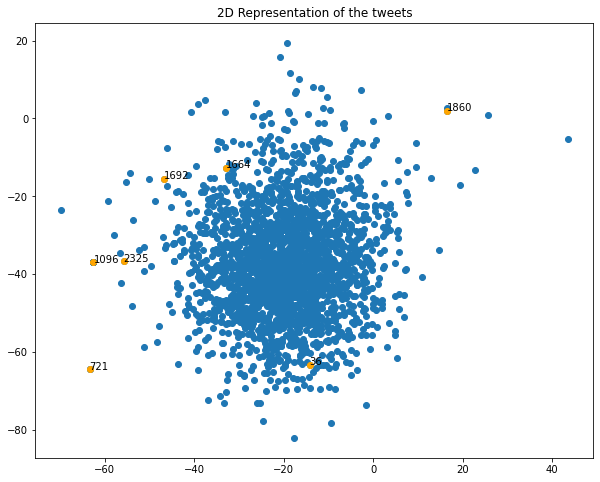

In [43]:
## Plot the 2D vector of each tweet
plt.figure(figsize=(10, 8))
plt.scatter(X_tweets[:, 0], X_tweets[:, 1])

# list of tweets we want to plot
tw_ids = [1860, 721, 1692, 1664,
          1096, 2325, 36]

for tw_i in tw_ids:
    plt.annotate(tw_i, xy=(X_tweets[tw_i, 0], X_tweets[tw_i, 1]))
    plt.scatter(X_tweets[tw_i, 0], X_tweets[tw_i, 1], color = 'orange')

plt.title('2D Representation of the tweets')
plt.show()